In [1]:
# Import necessary packages

import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from scipy import stats
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.special import erf

print('All modules imported!')

All modules imported!


## Process and Evaluate 10-300K AC Susceptibility Data

In [2]:
# Import the datafile
# skipping the first 26 lines and reading the next line as a header
data = pd.read_csv('./AND100-810-ac4ft-10-300K.ac.dat.csv',sep=',', skiprows=26, header=1)

# enter the specimen mass in grams for later normalization
Mass= 0.14941

# View the first few rows for visual inspection
data.head()

,Time,Comment,Field (Oe),Temperature (K),m' (emu),m' Scan Std Dev,"m"" (emu)","m"" Scan Std Dev",Amplitude (emu),Amplitude Scan Std Dev,...,Clock Frequency,Amplifier Gain,AC Filter,Two Point Measurement,Scan Length,Settling Time (sec),Delta Temp (K),Rot Position (Oe),Error,% Clipped
0,1713482211,NaN,0.0,10.0,0.000363,1.900000e-07,0.000032,2.100000e-08,0.000364,1.900000e-07,...,2,0,3,1,4.0,1,0.003180,0.0,0,0.0
1,1713482404,NaN,0.0,10.0,0.000322,1.580000e-07,0.000024,2.900000e-09,0.000323,1.580000e-07,...,3,0,2,1,4.0,1,0.000947,0.0,0,0.0
2,1713482566,NaN,0.0,10.0,0.000292,1.030000e-07,0.000017,1.940000e-08,0.000293,1.030000e-07,...,4,0,1,1,4.0,1,0.001890,0.0,0,0.0
3,1713482724,NaN,0.0,10.0,0.000271,1.730000e-07,0.000011,1.010000e-07,0.000271,1.740000e-07,...,4,0,0,1,4.0,1,0.000948,0.0,0,0.0
4,1713483258,NaN,0.0,15.0,0.000679,1.410000e-06,0.000117,3.020000e-07,0.000689,1.440000e-06,...,2,0,3,1,4.0,1,0.005140,0.0,0,0.0


In [3]:
data['Mass (g)']= Mass

# Calculating Mass-Normalized Susceptibilities in SI

# Convert Magnetic Field (Oe) to Magnetic Field Strength (A/m)
data["Magnetic Field (A/m)"]= (data["Drive Amplitude (Oe)"] * (1000/(4*np.pi)))

# Calculate mass-normalized In-phase AC susceptibility from Field Strength H (A/m) and Magnetization (1 emu/gr = 1 Am2/kg)
data["AC X' (m^3/kg)"]= (data["m' (emu)"] /Mass) / (data['Magnetic Field (A/m)'])

# Calculate mass-normalized Out-of-phase AC susceptibility from Field Strength H (A/m) and Magnetization (1 emu/gr = 1 Am2/kg)
data["AC X'' (m^3/kg)"]= (data['m" (emu)'] /Mass) / (data['Magnetic Field (A/m)'])

In [4]:
# Find unique Frequency values
freq = data['Wave Frequency (Hz)'].unique()#only shows unique/non-repeating values

print(freq[0])
print(freq[1])
print(freq[2])
print(freq[3])

1.0
10.0
99.8
997.0


In [5]:
# Add the three frequencies to vectors

freq_1 = []
for i in range(len(data)):
    if (data['Wave Frequency (Hz)'][i]==freq[0]):
        # So here we are appending whatever information we want. Running this loop multiple times will always add new entries
        freq_1.append(data[['Temperature (K)','Wave Frequency (Hz)',"AC X' (m^3/kg)","AC X'' (m^3/kg)"]].values[i])

freq_10 = []
for i in range(len(data)):
    if (data['Wave Frequency (Hz)'][i]==freq[1]):
        # So here we are appending whatever information we want. Running this loop multiple times will always add new entries
        freq_10.append(data[['Temperature (K)','Wave Frequency (Hz)',"AC X' (m^3/kg)","AC X'' (m^3/kg)"]].values[i])

freq_100 = []
for i in range(len(data)):
    if (data['Wave Frequency (Hz)'][i]==freq[2]):
        # So here we are appending whatever information we want. Running this loop multiple times will always add new entries
        freq_100.append(data[['Temperature (K)','Wave Frequency (Hz)',"AC X' (m^3/kg)","AC X'' (m^3/kg)"]].values[i])
        
freq_1000 = []
for i in range(len(data)):
    if (data['Wave Frequency (Hz)'][i]==freq[3]):
        # So here we are appending whatever information we want. Running this loop multiple times will always add new entries
        freq_1000.append(data[['Temperature (K)','Wave Frequency (Hz)',"AC X' (m^3/kg)","AC X'' (m^3/kg)"]].values[i])        
        
# Make new Data Frame
freq_1 = pd.DataFrame(freq_1)
freq_1.columns=['Temp (K)','Freq 1',"X' 1Hz","X'' 1Hz"]

freq_10 = pd.DataFrame(freq_10)
freq_10.columns=['Temp 2 (K)','Freq 2',"X' 10Hz","X'' 10Hz"]

freq_100 = pd.DataFrame(freq_100)
freq_100.columns=['Temp 3 (K)','Freq 3',"X' 100Hz","X'' 100Hz"]

freq_1000 = pd.DataFrame(freq_1000)
freq_1000.columns=['Temp 4 (K)','Freq 4',"X' 1000Hz","X'' 1000Hz"]

#print(freq_1)
#print(freq_10)
#print(freq_100)
#print(freq_1000)

In [6]:
# Concatenate dataframes using pandas.concat([df1, df2], axis="columns")
ct = pd.concat([freq_1, freq_10, freq_100, freq_1000], axis="columns")

# Drop repeat columns using the drop function
ct.drop(['Temp 2 (K)', 'Temp 3 (K)'], inplace=True, axis=1)

#ct

In [7]:
# Calculate % Frequency-dependent X (Xfd%) as (Xlf-Xhf)/Xlf x100, and add to CT dataframe
ct["%Xfd1"]= ((ct["X' 1Hz"] - ct["X' 10Hz"])/ct["X' 1Hz"])*100
ct["%Xfd2"]= ((ct["X' 10Hz"] - ct["X' 100Hz"])/ct["X' 10Hz"])*100
ct["%Xfd3"]= ((ct["X' 100Hz"] - ct["X' 1000Hz"])/ct["X' 100Hz"])*100

# Calculate Pi/2 parameter as -(PI()/2)*((X'1Hz-X'10Hz)/(LN(1Hz)-LN(10Hz))) and add to CT dataframe
ct['Xvisc1']= -(np.pi/2)*((ct["X' 1Hz"]-ct["X' 10Hz"])/((np.log(ct['Freq 1'])-(np.log(ct['Freq 2'])))))
ct['Xvisc2']= -(np.pi/2)*((ct["X' 10Hz"]-ct["X' 100Hz"])/((np.log(ct['Freq 2'])-(np.log(ct['Freq 3'])))))
ct['Xvisc3']= -(np.pi/2)*((ct["X' 100Hz"]-ct["X' 1000Hz"])/((np.log(ct['Freq 3'])-(np.log(ct['Freq 4'])))))

#ct.dtypes to check what types of data
#ct=ct.astype(float) #convert pandas column into a float

#ct

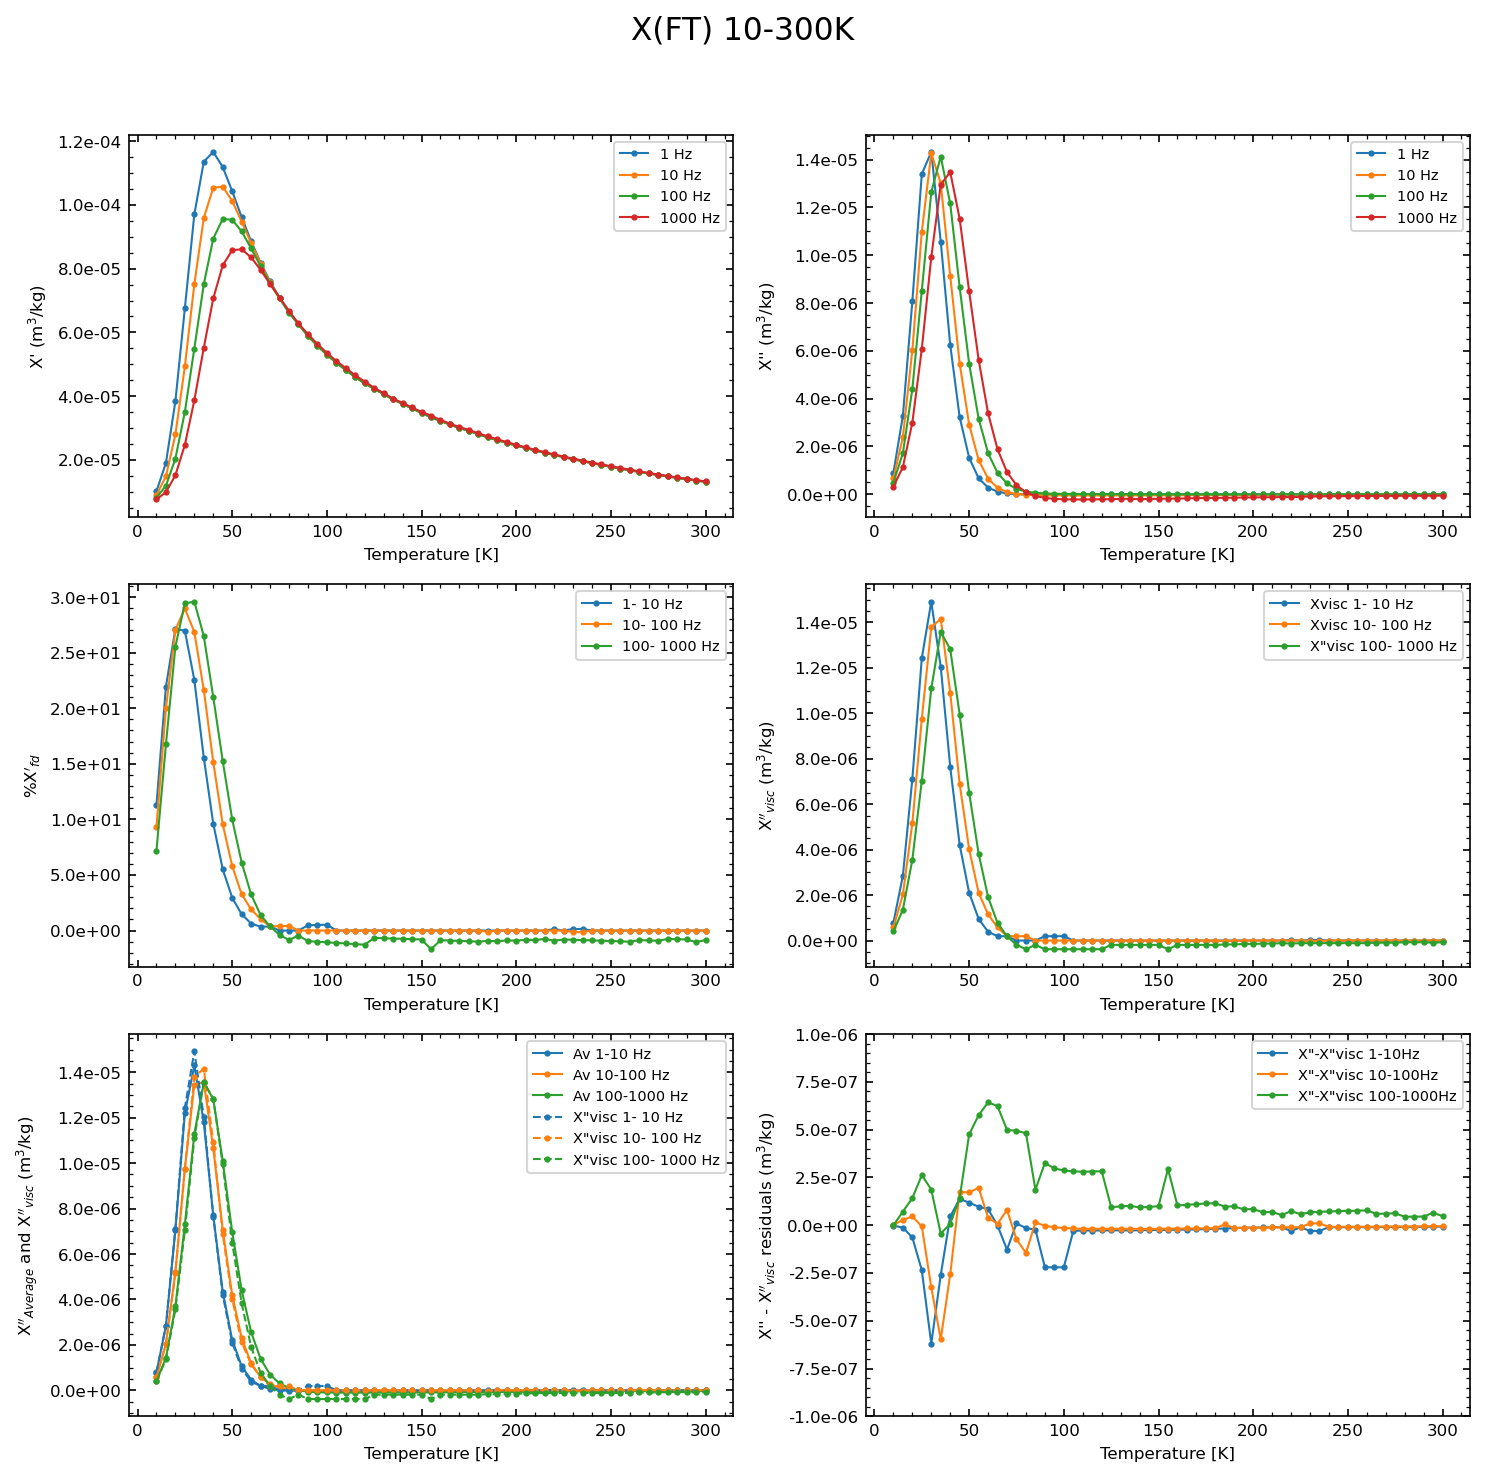

In [8]:
# Plot the data

fig = plt.figure(figsize=[10,10], dpi=150)

ax1 = plt.subplot(321) #3 row, 2 columns, position 1
# X'
ax1.plot(ct['Temp (K)'],ct["X' 1Hz"],'-o', markersize=2, linewidth=1, label='1 Hz')
ax1.plot(ct['Temp (K)'],ct["X' 10Hz"],'-o', markersize=2, linewidth=1, label='10 Hz')
ax1.plot(ct['Temp (K)'],ct["X' 100Hz"],'-o', markersize=2, linewidth=1, label='100 Hz')
ax1.plot(ct['Temp (K)'],ct["X' 1000Hz"],'-o', markersize=2, linewidth=1, label='1000 Hz')

ax2 = plt.subplot(322) #3 row, 2 columns, position 2
# X"
ax2.plot(ct['Temp (K)'],ct["X'' 1Hz"],'-o', markersize=2, linewidth=1, label='1 Hz')
ax2.plot(ct['Temp (K)'],ct["X'' 10Hz"],'-o', markersize=2, linewidth=1, label='10 Hz')
ax2.plot(ct['Temp (K)'],ct["X'' 100Hz"],'-o', markersize=2, linewidth=1, label='100 Hz')
ax2.plot(ct['Temp (K)'],ct["X'' 1000Hz"],'-o', markersize=2, linewidth=1, label='1000 Hz')

ax3 = plt.subplot(323) #3 row, 2 columns, position 3
# %Xfd
ax3.plot(ct['Temp (K)'],ct["%Xfd1"],'-o', markersize=2, linewidth=1, label='1- 10 Hz')
ax3.plot(ct['Temp (K)'],ct["%Xfd2"],'-o', markersize=2, linewidth=1, label='10- 100 Hz')
ax3.plot(ct['Temp (K)'],ct["%Xfd3"],'-o', markersize=2, linewidth=1, label='100- 1000 Hz')

ax4 = plt.subplot(324) #3 row, 2 columns, position 4
# Xvisc
ax4.plot(ct['Temp (K)'],ct["Xvisc1"],'-o', markersize=2, linewidth=1, label='Xvisc 1- 10 Hz')
ax4.plot(ct['Temp (K)'],ct["Xvisc2"],'-o', markersize=2, linewidth=1, label='Xvisc 10- 100 Hz')
ax4.plot(ct['Temp (K)'],ct["Xvisc3"],'-o', markersize=2, linewidth=1, label='X"visc 100- 1000 Hz')

ax5 = plt.subplot(325) #3 row, 2 columns, position 5
# X"av and Xvisc
ax5.plot(ct['Temp (K)'],((ct["X'' 1Hz"]+ct["X'' 10Hz"])/2),'-o', markersize=2, linewidth=1, color= 'tab:blue', label='Av 1-10 Hz')
ax5.plot(ct['Temp (K)'],((ct["X'' 10Hz"]+ct["X'' 100Hz"])/2),'-o', markersize=2, linewidth=1, color= 'tab:orange', label='Av 10-100 Hz')
ax5.plot(ct['Temp (K)'],((ct["X'' 100Hz"]+ct["X'' 1000Hz"])/2),'-o', markersize=2, linewidth=1, color= 'tab:green', label='Av 100-1000 Hz')

ax5.plot(ct['Temp (K)'],ct["Xvisc1"],'--o', markersize=2, linewidth=1, color='tab:blue', label='X"visc 1- 10 Hz')
ax5.plot(ct['Temp (K)'],ct["Xvisc2"],'--o', markersize=2, linewidth=1, color='tab:orange', label='X"visc 10- 100 Hz')
ax5.plot(ct['Temp (K)'],ct["Xvisc3"],'--o', markersize=2, linewidth=1, color='tab:green', label='X"visc 100- 1000 Hz')

ax6 = plt.subplot(326) #3 row, 2 columns, position 6
# X"av and Xvisc residuals
ax6.plot(ct['Temp (K)'],((ct["X'' 1Hz"]+ct["X'' 10Hz"])/2)-ct["Xvisc1"],'-o', markersize=2, linewidth=1, label='X"-X"visc 1-10Hz')
ax6.plot(ct['Temp (K)'],((ct["X'' 10Hz"]+ct["X'' 100Hz"])/2)-ct["Xvisc2"],'-o', markersize=2, linewidth=1, label='X"-X"visc 10-100Hz')
ax6.plot(ct['Temp (K)'],((ct["X'' 100Hz"]+ct["X'' 1000Hz"])/2)-ct["Xvisc3"],'-o', markersize=2, linewidth=1, label='X"-X"visc 100-1000Hz')

# Customization
ax1.set_xlabel('Temperature [K]', color='black', fontsize=8)
ax1.set_ylabel("X' ($\mathrm{m}^3$/kg)", color='black', fontsize=8)
ax1.minorticks_on()
ax1.tick_params(which= 'both', labelcolor='k', labelsize=8, top='bool', right= 'bool', direction='in')
ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
ax1.legend(fontsize='x-small',frameon=True, loc='best')

ax2.set_xlabel('Temperature [K]', color='black', fontsize=8)
ax2.set_ylabel("X'' ($\mathrm{m}^3$/kg)", color='black', fontsize=8)
ax2.minorticks_on()
ax2.tick_params(which= 'both', labelcolor='k', labelsize=8, top='bool', right= 'bool', direction='in')
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
ax2.legend(fontsize='x-small',frameon=True, loc='best')

ax3.set_xlabel('Temperature [K]', color='black', fontsize=8)
ax3.set_ylabel("$\%\mathrm{X'}_{fd}$", color='black', fontsize=8)
ax3.tick_params(labelcolor='k', labelsize=8)
ax3.ticklabel_format(axis="y", style="scientific", scilimits=(0,0))
ax3.minorticks_on()
ax3.tick_params(which= 'both', labelcolor='k', labelsize=8, top='bool', right= 'bool', direction='in')
ax3.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
ax3.legend(fontsize='x-small',frameon=True, loc='best')

ax4.set_xlabel('Temperature [K]', color='black', fontsize=8)
ax4.set_ylabel("$\mathrm{X''}_{visc}$ ($\mathrm{m}^3$/kg)", color='black', fontsize=8)
ax4.minorticks_on()
ax4.tick_params(which= 'both', labelcolor='k', labelsize=8, top='bool', right= 'bool', direction='in')
ax4.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
ax4.legend(fontsize='x-small',frameon=True, loc='best')

ax5.set_xlabel('Temperature [K]', color='black', fontsize=8)
ax5.set_ylabel("$\mathrm{X''}_{Average}$ and $\mathrm{X''}_{visc}$ ($\mathrm{m}^3$/kg)", color='black', fontsize=8)
ax5.minorticks_on()
ax5.tick_params(which= 'both', labelcolor='k', labelsize=8, top='bool', right= 'bool', direction='in')
ax5.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
ax5.legend(fontsize='x-small',frameon=True, loc='best')

ax6.set_xlabel('Temperature [K]', color='black', fontsize=8)
ax6.set_ylabel("X'' - $\mathrm{X''}_{visc}$ residuals ($\mathrm{m}^3$/kg)", color='black', fontsize=8)
ax6.minorticks_on()
ax6.tick_params(which= 'both', labelcolor='k', labelsize=8, top='bool', right= 'bool', direction='in')
ax6.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
ax6.legend(fontsize='x-small',frameon=True, loc='best')
ax6.set_ylim(-1e-6, +1e-6)

fig.tight_layout()
plt.subplots_adjust(top=0.9)

fig.suptitle('X(FT) 10-300K', fontsize= 15)

#Save
#plt.savefig('AND100-810C_AC(4FT)_10-300')

plt.show()

## Investigate Low Temperature (5-80K) AC Susceptibility Peak

In [9]:
# Import the datafile
# skipping the first 26 rows and reading the next line as a header
data2 = pd.read_csv('./AND100-810-ac4ft-5-80K.ac.dat.csv',sep=',', skiprows=26, header=1)

# View the first few rows for visual inspection
data2.head()

,Time,Comment,Field (Oe),Temperature (K),m' (emu),m' Scan Std Dev,"m"" (emu)","m"" Scan Std Dev",Amplitude (emu),Amplitude Scan Std Dev,...,Clock Frequency,Amplifier Gain,AC Filter,Two Point Measurement,Scan Length,Settling Time (sec),Delta Temp (K),Rot Position (Oe),Error,% Clipped
0,1715124079,NaN,0.0,5.00,0.000312,1.990000e-07,0.000008,1.670000e-08,0.000313,2.000000e-07,...,2,0,3,1,4.0,1,0.00167,0.0,0,0.0
1,1715124288,NaN,0.0,5.00,0.000301,3.830000e-08,0.000006,8.510000e-09,0.000301,3.850000e-08,...,3,0,2,1,4.0,1,0.00116,0.0,0,0.0
2,1715124448,NaN,0.0,5.00,0.000292,2.460000e-08,0.000005,8.310000e-09,0.000292,2.470000e-08,...,4,0,1,1,4.0,1,0.00154,0.0,0,0.0
3,1715124624,NaN,0.0,5.00,0.000286,9.040000e-08,0.000003,1.050000e-07,0.000286,9.090000e-08,...,4,0,0,1,4.0,1,0.00141,0.0,0,0.0
4,1715125105,NaN,0.0,6.97,0.000331,4.800000e-07,0.000016,9.150000e-08,0.000331,4.830000e-07,...,2,0,3,1,4.0,1,0.00828,0.0,0,0.0


In [10]:
# Calculating Mass-Normalized Susceptibilities in SI

# Magnetic Field Strength (A/m)
data2["Magnetic Field (A/m)"]= (data2["Drive Amplitude (Oe)"] * (1000/(4*np.pi)))

# In-phase AC susceptibility
# Magnetization: 1 emu/gr = 1 Am2/kg
# Mass-normalized Susceptibility (X)= (Am2/kg)/(A/m)
data2["AC X' (m^3/kg)"]= (data2["m' (emu)"] /Mass) / (data2['Magnetic Field (A/m)'])

# Out-of-phase AC susceptibility
data2["AC X'' (m^3/kg)"]= (data2['m" (emu)'] /Mass) / (data2['Magnetic Field (A/m)'])

In [11]:
# Find unique Frequency values
freq = data2['Wave Frequency (Hz)'].unique()#only shows unique/non-repeating values

print(freq[0])
print(freq[1])
print(freq[2])
print(freq[3])

1.0
10.0
99.8
997.0


In [12]:
# Add the three frequencies to vectors

freq_1 = []
for i in range(len(data2)):
    if (data2['Wave Frequency (Hz)'][i]==freq[0]):
        # So here we are appending whatever information we want. Running this loop multiple times will always add new entries
        freq_1.append(data2[['Temperature (K)','Wave Frequency (Hz)',"AC X' (m^3/kg)","AC X'' (m^3/kg)"]].values[i])

freq_10 = []
for i in range(len(data2)):
    if (data2['Wave Frequency (Hz)'][i]==freq[1]):
        # So here we are appending whatever information we want. Running this loop multiple times will always add new entries
        freq_10.append(data2[['Temperature (K)','Wave Frequency (Hz)',"AC X' (m^3/kg)","AC X'' (m^3/kg)"]].values[i])

freq_100 = []
for i in range(len(data2)):
    if (data['Wave Frequency (Hz)'][i]==freq[2]):
        # So here we are appending whatever information we want. Running this loop multiple times will always add new entries
        freq_100.append(data2[['Temperature (K)','Wave Frequency (Hz)',"AC X' (m^3/kg)","AC X'' (m^3/kg)"]].values[i])
        
freq_1000 = []
for i in range(len(data2)):
    if (data2['Wave Frequency (Hz)'][i]==freq[3]):
        # So here we are appending whatever information we want. Running this loop multiple times will always add new entries
        freq_1000.append(data2[['Temperature (K)','Wave Frequency (Hz)',"AC X' (m^3/kg)","AC X'' (m^3/kg)"]].values[i])        
        
# Make new Data Frame
freq_1 = pd.DataFrame(freq_1)
freq_1.columns=['Temp (K)','Freq 1',"X' 1Hz","X'' 1Hz"]

freq_10 = pd.DataFrame(freq_10)
freq_10.columns=['Temp 2 (K)','Freq 2',"X' 10Hz","X'' 10Hz"]

freq_100 = pd.DataFrame(freq_100)
freq_100.columns=['Temp 3 (K)','Freq 3',"X' 100Hz","X'' 100Hz"]

freq_1000 = pd.DataFrame(freq_1000)
freq_1000.columns=['Temp 4 (K)','Freq 4',"X' 1000Hz","X'' 1000Hz"]

#print(freq_1)
#print(freq_10)
#print(freq_100)
#print(freq_1000)

In [13]:
# Concatenate dataframes using pandas.concat([df1, df2], axis="columns")
ct2 = pd.concat([freq_1, freq_10, freq_100, freq_1000], axis="columns")

# Drop repeat columns using the drop function
ct2.drop(['Temp 2 (K)', 'Temp 3 (K)'], inplace=True, axis=1)
#ct

In [14]:
# Calculate % Frequency-dependent X (Xfd%) as (Xlf-Xhf)/Xlf x100, and add to CT2 dataframe
ct2["%Xfd1"]= ((ct2["X' 1Hz"] - ct2["X' 10Hz"])/ct2["X' 1Hz"])*100
ct2["%Xfd2"]= ((ct2["X' 10Hz"] - ct2["X' 100Hz"])/ct2["X' 10Hz"])*100
ct2["%Xfd3"]= ((ct2["X' 100Hz"] - ct2["X' 1000Hz"])/ct2["X' 100Hz"])*100

# Calculate Pi/2 parameter as -(PI()/2)*((X'1Hz-X'10Hz)/(LN(1Hz)-LN(10Hz))) and add to CT2 dataframe
ct2['Xvisc1']= -(np.pi/2)*((ct2["X' 1Hz"]-ct2["X' 10Hz"])/((np.log(ct2['Freq 1'])-(np.log(ct2['Freq 2'])))))
ct2['Xvisc2']= -(np.pi/2)*((ct2["X' 10Hz"]-ct2["X' 100Hz"])/((np.log(ct2['Freq 2'])-(np.log(ct2['Freq 3'])))))
ct2['Xvisc3']= -(np.pi/2)*((ct2["X' 100Hz"]-ct2["X' 1000Hz"])/((np.log(ct2['Freq 3'])-(np.log(ct2['Freq 4'])))))
#ct2.dtypes to check what types of data
#ct2=ct2.astype(float) #convert pandas column into a float

#ct2

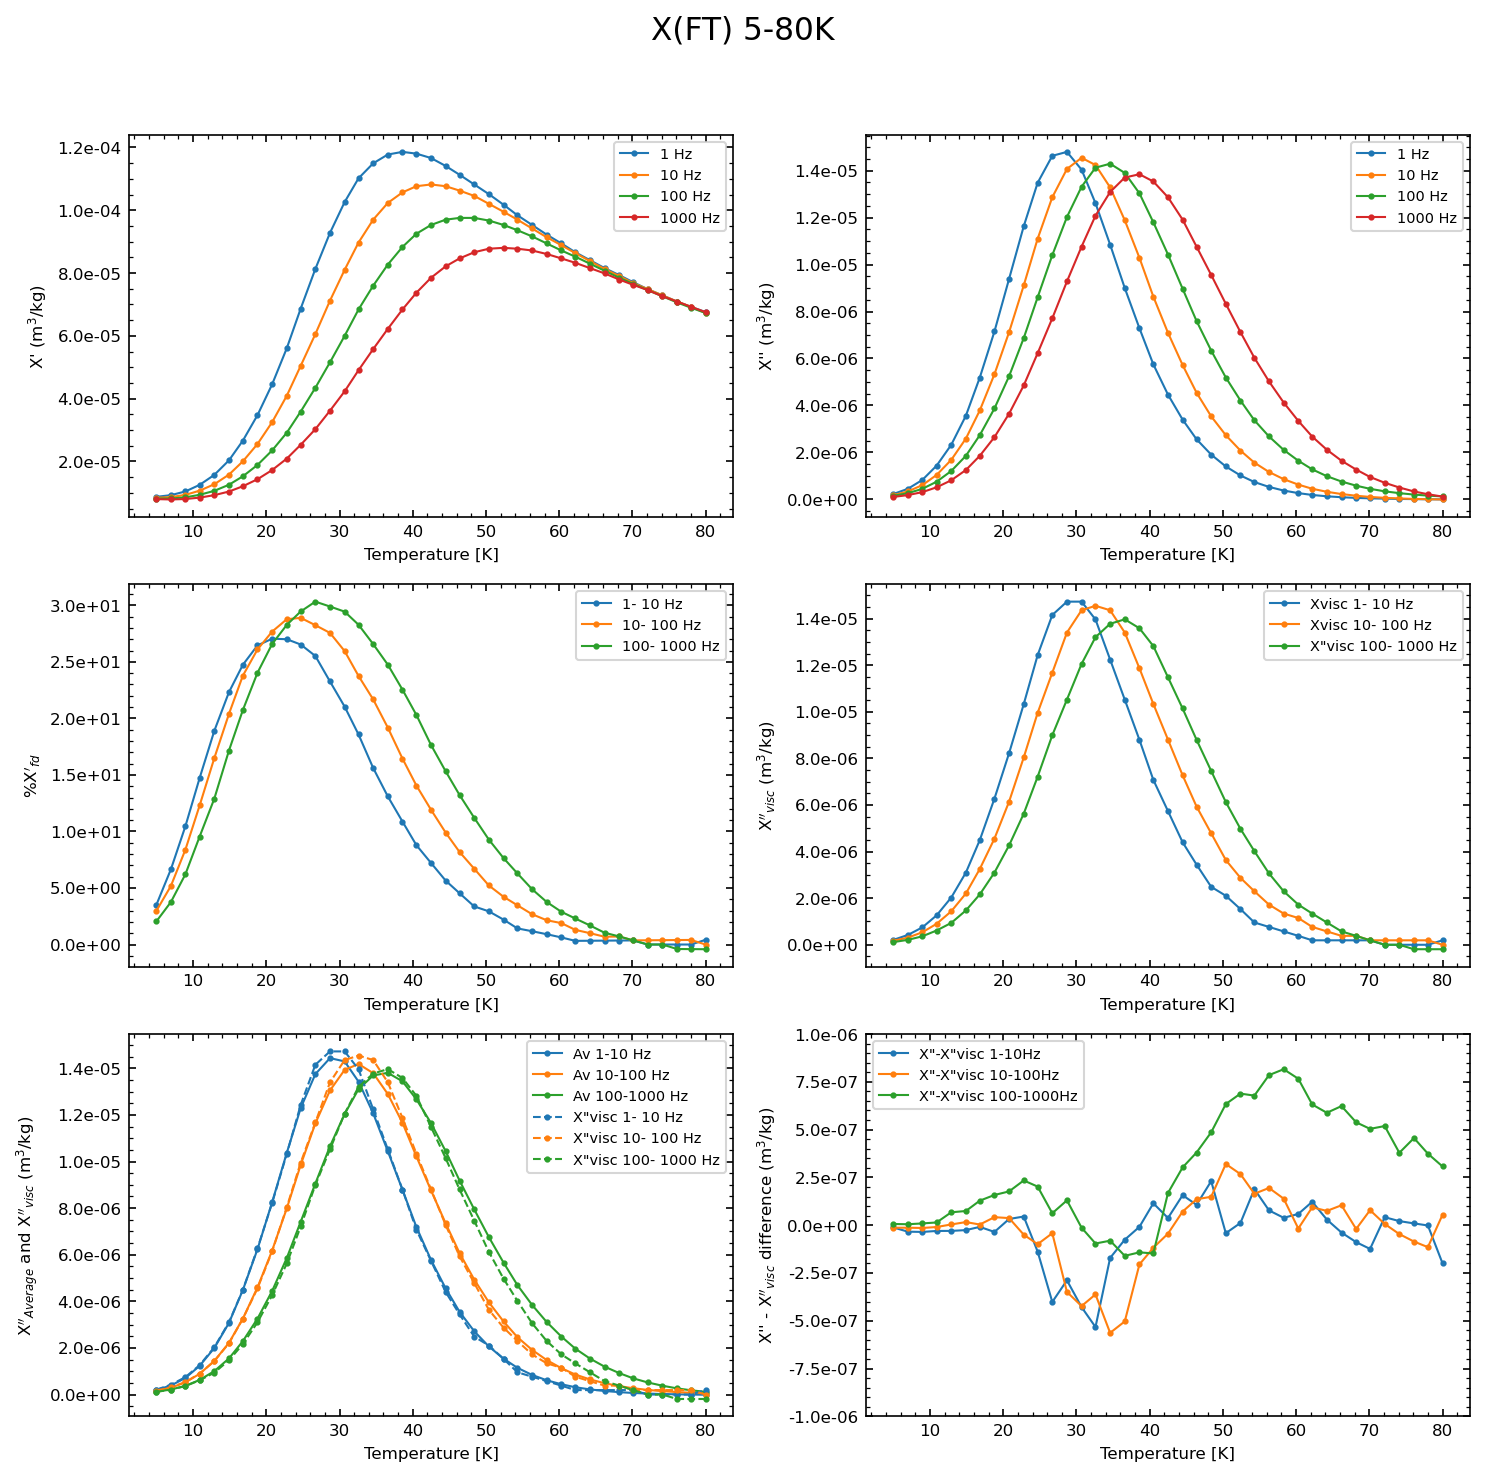

In [15]:
#Plot the data

fig = plt.figure(figsize=[10,10], dpi=150)

ax1 = plt.subplot(321) #3 row, 2 columns, position 1
# X'
ax1.plot(ct2['Temp (K)'],ct2["X' 1Hz"],'-o', markersize=2, linewidth=1, label='1 Hz')
ax1.plot(ct2['Temp (K)'],ct2["X' 10Hz"],'-o', markersize=2, linewidth=1, label='10 Hz')
ax1.plot(ct2['Temp (K)'],ct2["X' 100Hz"],'-o', markersize=2, linewidth=1, label='100 Hz')
ax1.plot(ct2['Temp (K)'],ct2["X' 1000Hz"],'-o', markersize=2, linewidth=1, label='1000 Hz')

ax2 = plt.subplot(322) #3 row, 2 columns, position 2
# X"
ax2.plot(ct2['Temp (K)'],ct2["X'' 1Hz"],'-o', markersize=2, linewidth=1, label='1 Hz')
ax2.plot(ct2['Temp (K)'],ct2["X'' 10Hz"],'-o', markersize=2, linewidth=1, label='10 Hz')
ax2.plot(ct2['Temp (K)'],ct2["X'' 100Hz"],'-o', markersize=2, linewidth=1, label='100 Hz')
ax2.plot(ct2['Temp (K)'],ct2["X'' 1000Hz"],'-o', markersize=2, linewidth=1, label='1000 Hz')

ax3 = plt.subplot(323) #3 row, 2 columns, position 3
# %Xfd
ax3.plot(ct2['Temp (K)'],ct2["%Xfd1"],'-o', markersize=2, linewidth=1, label='1- 10 Hz')
ax3.plot(ct2['Temp (K)'],ct2["%Xfd2"],'-o', markersize=2, linewidth=1, label='10- 100 Hz')
ax3.plot(ct2['Temp (K)'],ct2["%Xfd3"],'-o', markersize=2, linewidth=1, label='100- 1000 Hz')

ax4 = plt.subplot(324) #3 row, 2 columns, position 4
# Xvisc
ax4.plot(ct2['Temp (K)'],ct2["Xvisc1"],'-o', markersize=2, linewidth=1, label='Xvisc 1- 10 Hz')
ax4.plot(ct2['Temp (K)'],ct2["Xvisc2"],'-o', markersize=2, linewidth=1, label='Xvisc 10- 100 Hz')
ax4.plot(ct2['Temp (K)'],ct2["Xvisc3"],'-o', markersize=2, linewidth=1, label='X"visc 100- 1000 Hz')

ax5 = plt.subplot(325) #3 row, 2 columns, position 5
# X"av and Xvisc
ax5.plot(ct2['Temp (K)'],((ct2["X'' 1Hz"]+ct2["X'' 10Hz"])/2),'-o', markersize=2, linewidth=1, color= 'tab:blue', label='Av 1-10 Hz')
ax5.plot(ct2['Temp (K)'],((ct2["X'' 10Hz"]+ct2["X'' 100Hz"])/2),'-o', markersize=2, linewidth=1, color= 'tab:orange', label='Av 10-100 Hz')
ax5.plot(ct2['Temp (K)'],((ct2["X'' 100Hz"]+ct2["X'' 1000Hz"])/2),'-o', markersize=2, linewidth=1, color= 'tab:green', label='Av 100-1000 Hz')

ax5.plot(ct2['Temp (K)'],ct2["Xvisc1"],'--o', markersize=2, linewidth=1, color='tab:blue', label='X"visc 1- 10 Hz')
ax5.plot(ct2['Temp (K)'],ct2["Xvisc2"],'--o', markersize=2, linewidth=1, color='tab:orange', label='X"visc 10- 100 Hz')
ax5.plot(ct2['Temp (K)'],ct2["Xvisc3"],'--o', markersize=2, linewidth=1, color='tab:green', label='X"visc 100- 1000 Hz')

ax6 = plt.subplot(326) #3 row, 2 columns, position 6
# X"av and Xvisc residuals
ax6.plot(ct2['Temp (K)'],((ct2["X'' 1Hz"]+ct2["X'' 10Hz"])/2)-ct2["Xvisc1"],'-o', markersize=2, linewidth=1, label='X"-X"visc 1-10Hz')
ax6.plot(ct2['Temp (K)'],((ct2["X'' 10Hz"]+ct2["X'' 100Hz"])/2)-ct2["Xvisc2"],'-o', markersize=2, linewidth=1, label='X"-X"visc 10-100Hz')
ax6.plot(ct2['Temp (K)'],((ct2["X'' 100Hz"]+ct2["X'' 1000Hz"])/2)-ct2["Xvisc3"],'-o', markersize=2, linewidth=1, label='X"-X"visc 100-1000Hz')

# Customization
ax1.set_xlabel('Temperature [K]', color='black', fontsize=8)
ax1.set_ylabel("X' ($\mathrm{m}^3$/kg)", color='black', fontsize=8)
ax1.minorticks_on()
ax1.tick_params(which= 'both', labelcolor='k', labelsize=8, top='bool', right= 'bool', direction='in')
ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
ax1.legend(fontsize='x-small',frameon=True, loc='best')

ax2.set_xlabel('Temperature [K]', color='black', fontsize=8)
ax2.set_ylabel("X'' ($\mathrm{m}^3$/kg)", color='black', fontsize=8)
# Size of the number in labels
ax2.minorticks_on()
ax2.tick_params(which= 'both', labelcolor='k', labelsize=8, top='bool', right= 'bool', direction='in')
# Axis notation: scientific or plain
#ax2.ticklabel_format(axis="y", style="scientific", scilimits=(0,0))
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
# Set the legend outside the graph
ax2.legend(fontsize='x-small',frameon=True, loc='best')

ax3.set_xlabel('Temperature [K]', color='black', fontsize=8)
ax3.set_ylabel("$\%\mathrm{X'}_{fd}$", color='black', fontsize=8)
# Size of the number in labels
ax3.tick_params(labelcolor='k', labelsize=8)
# Axis notation: scientific or plain
ax3.ticklabel_format(axis="y", style="scientific", scilimits=(0,0))
# Set the legend outside the graph
# Size of the number in labels
ax3.minorticks_on()
ax3.tick_params(which= 'both', labelcolor='k', labelsize=8, top='bool', right= 'bool', direction='in')
# Axis notation: scientific or plain
#ax3.ticklabel_format(axis="y", style="scientific", scilimits=(0,0))
ax3.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
# Set the legend outside the graph
ax3.legend(fontsize='x-small',frameon=True, loc='best')

ax4.set_xlabel('Temperature [K]', color='black', fontsize=8)
ax4.set_ylabel("$\mathrm{X''}_{visc}$ ($\mathrm{m}^3$/kg)", color='black', fontsize=8)
# Size of the number in labels
ax4.minorticks_on()
ax4.tick_params(which= 'both', labelcolor='k', labelsize=8, top='bool', right= 'bool', direction='in')
# Axis notation: scientific or plain
#ax4.ticklabel_format(axis="y", style="scientific", scilimits=(0,0))
ax4.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
# Set the legend outside the graph
ax4.legend(fontsize='x-small',frameon=True, loc='best')

ax5.set_xlabel('Temperature [K]', color='black', fontsize=8)
ax5.set_ylabel("$\mathrm{X''}_{Average}$ and $\mathrm{X''}_{visc}$ ($\mathrm{m}^3$/kg)", color='black', fontsize=8)
# Size of the number in labels
ax5.minorticks_on()
ax5.tick_params(which= 'both', labelcolor='k', labelsize=8, top='bool', right= 'bool', direction='in')
# Axis notation: scientific or plain
ax5.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
# Set the legend outside the graph
ax5.legend(fontsize='x-small',frameon=True, loc='best')

ax6.set_xlabel('Temperature [K]', color='black', fontsize=8)
ax6.set_ylabel("X'' - $\mathrm{X''}_{visc}$ difference ($\mathrm{m}^3$/kg)", color='black', fontsize=8)
# Size of the number in labels
ax6.minorticks_on()
ax6.tick_params(which= 'both', labelcolor='k', labelsize=8, top='bool', right= 'bool', direction='in')
# Axis notation: scientific or plain
ax6.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
# Set the legend outside the graph
ax6.legend(fontsize='x-small',frameon=True, loc='best')
ax6.set_ylim(-1e-6, +1e-6)

fig.tight_layout()
plt.subplots_adjust(top=0.9)

fig.suptitle('X(FT) 5-80K', fontsize= 15) #y=1.05)
#Save
#plt.savefig('AND100-810C_AC(4FT)_5-80K')

plt.show()

## Fit Skewed Gaussians to X" peak data

In [16]:
# Make dataframes for each frequency x and y for the peak data only
# For Gx1Hz and Gy1Hz
Gx1Hz = ct2["Temp (K)"]#.drop(ct.index[11:])
Gy1Hz = ct2["X'' 1Hz"]#.drop(ct.index[11:])

# For Gx10Hz and Gy10Hz
Gx10Hz = ct2["Temp (K)"]#.drop(ct.index[12:])
Gy10Hz = ct2["X'' 10Hz"]#.drop(ct.index[12:])

# For Gx100Hz and Gy100Hz
Gx100Hz = ct2["Temp (K)"]#.drop(ct.index[13:])
Gy100Hz = ct2["X'' 100Hz"]#.drop(ct.index[13:])

# For Gx1000Hz and Gy1000Hz
Gx1000Hz = ct2["Temp (K)"]#.drop(ct.index[14:])
Gy1000Hz = ct2["X'' 1000Hz"]#.drop(ct.index[14:])

In [17]:
#Fit skewed gaussians

# Gaussian function with skewness
def gauss_skew(x, H, A, x0, sigma, gamma):
    arg = (x - x0) / sigma
    return H + A * np.exp(-0.5 * arg**2) * (1 + erf(gamma * arg / np.sqrt(2)))

# Fitting function with skewness
def gauss_fit_skew(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss_skew, x, y, p0=[min(y), max(y), mean, sigma, 0])
    return popt

# Process data and generate outputs for each dataset
def process_data(Gx, Gy):
    # Fit the skewed Gaussian
    H, A, x0, sigma, gamma = gauss_fit_skew(Gx, Gy)
    FWHM = 2.35482 * sigma  # Full Width at Half Maximum
    
    # Generate a higher resolution x-axis array
    Gx_high_res = np.linspace(min(Gx), max(Gx), 100)
    
    # Generate y-values for the fitted Gaussian using the high-res x-axis
    Gy_high_res = gauss_skew(Gx_high_res, *gauss_fit_skew(Gx, Gy))
    
    return Gx_high_res, Gy_high_res, x0, A

# Sample data
datasets = [
    (Gx1Hz, Gy1Hz),
    (Gx10Hz, Gy10Hz),
    (Gx100Hz, Gy100Hz),
    (Gx1000Hz, Gy1000Hz)
]

# Collect data and interpolated fits for all datasets
all_Gx_high_res = []
all_Gy_high_res = []

for Gx, Gy in datasets:
    Gx_high_res, Gy_high_res, _, _ = process_data(Gx, Gy)
    all_Gx_high_res.append(Gx_high_res)
    all_Gy_high_res.append(Gy_high_res)


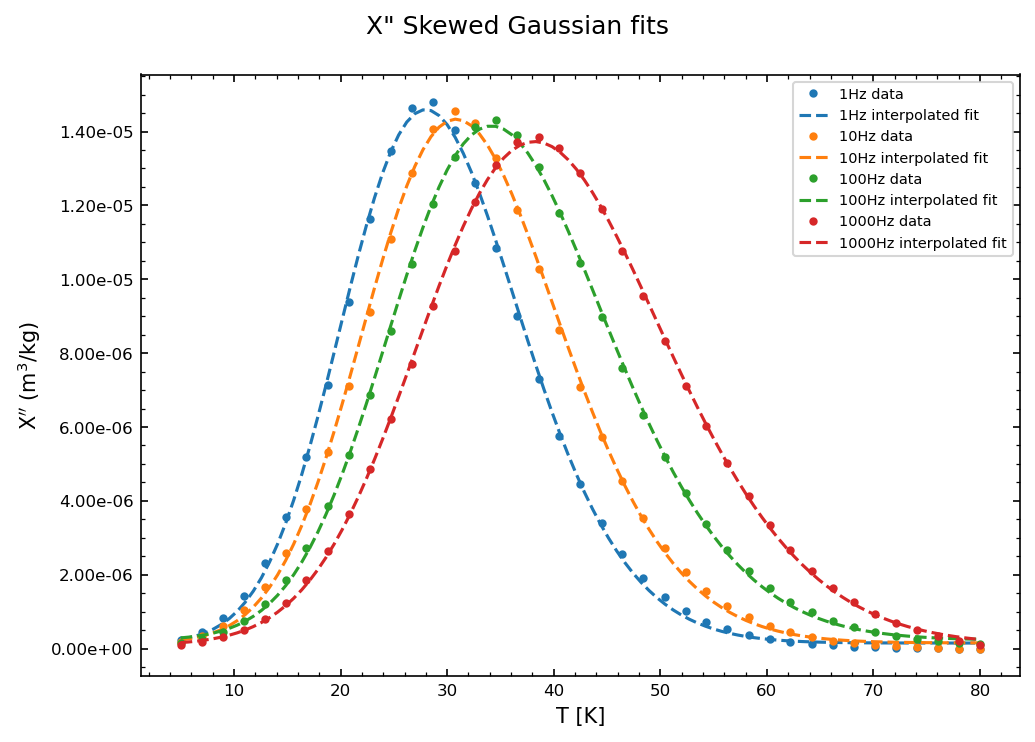

In [18]:
# Plot Gaussian fits
fig, ax = plt.subplots(figsize=[7,5], dpi=150)

# Plot data and interpolated fits for each dataset
for i, (Gx, Gy) in enumerate(datasets):
    color = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red'][i]
    label = ['1Hz', '10Hz', '100Hz', '1000Hz'][i]
    
    ax.plot(Gx, Gy, '.', color=color, label=f'{label} data')
    ax.plot(all_Gx_high_res[i], all_Gy_high_res[i], '--', color=color, label=f'{label} interpolated fit')

# Customization
ax.set_xlabel('T [K]', color='black', fontsize=10)
ax.set_ylabel("$\mathrm{X''}$ ($\mathrm{m}^3$/kg)", color='black', fontsize=10)
ax.legend(fontsize='x-small',frameon=True, loc='best')
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
ax.minorticks_on()
ax.tick_params(which='both', labelcolor='k', labelsize=8, top=True, right=True, direction='in')

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('X" Skewed Gaussian fits')

# Save
#plt.savefig('AND100-810_Xdp_interpol_Skewed_Gaussian')

plt.show()

## Generate Arrhenius Plot from Skewed Gaussian Fits

In [19]:
peak_values = []  # List to store peak values and their corresponding x-values

for Gx_high_res, Gy_high_res in zip(all_Gx_high_res, all_Gy_high_res):
    # Find the index of the maximum y-value
    max_index = np.argmax(Gy_high_res)
    
    # Extract the corresponding x and y values
    peak_x = Gx_high_res[max_index]
    peak_y = Gy_high_res[max_index]
    
    # Append the peak values and their corresponding x-values to the list
    peak_values.append((peak_x, peak_y))

# Print the extracted peak values
for i, (peak_x, peak_y) in enumerate(peak_values, start=1):
    print(f"Peak {i}: x = {peak_x}, y = {peak_y}")

Peak 1: x = 27.727272727272727, y = 1.4585757063762796e-05
Peak 2: x = 30.757575757575758, y = 1.4334583327735596e-05
Peak 3: x = 33.78787878787879, y = 1.4141668439202751e-05
Peak 4: x = 38.333333333333336, y = 1.3727348067951452e-05


In [20]:
# List of frequencies
frequencies = [1.0, 10.0, 100.0, 1000.0]

# Create an empty DataFrame
peak_df = pd.DataFrame(columns=['Frequency (Hz)', 'Peak Temperature (K)', 'Amplitude (m^3/kg)'])

# Populate the DataFrame with extracted peak values using pd.concat()
dfs = []

# Populate the list with DataFrames containing extracted peak values
for freq, (peak_x, peak_y) in zip(frequencies, peak_values):
    df = pd.DataFrame({'Frequency (Hz)': [freq], 'Peak Temperature (K)': [peak_x], 'Amplitude (m^3/kg)': [peak_y]})
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame using pd.concat()
peak_df = pd.concat(dfs, ignore_index=True)

# Display the DataFrame
print(peak_df)

   Frequency (Hz)  Peak Temperature (K)  Amplitude (m^3/kg)
0             1.0             27.727273            0.000015
1            10.0             30.757576            0.000014
2           100.0             33.787879            0.000014
3          1000.0             38.333333            0.000014


In [21]:
# Rename DF columns
peak_df.columns= ['f', 'Tp','Ap']
peak_df

,f,Tp,Ap
0,1.0,27.727273,0.000015
1,10.0,30.757576,0.000014
2,100.0,33.787879,0.000014
3,1000.0,38.333333,0.000014


In [22]:
# Calculate additional columns
peak_df['1/Tp'] = 1 / peak_df['Tp']
peak_df['ln(1/f)'] = np.log(1 / peak_df['f'])

# Print the DataFrame
print(peak_df)

        f         Tp        Ap      1/Tp   ln(1/f)
0     1.0  27.727273  0.000015  0.036066  0.000000
1    10.0  30.757576  0.000014  0.032512 -2.302585
2   100.0  33.787879  0.000014  0.029596 -4.605170
3  1000.0  38.333333  0.000014  0.026087 -6.907755


In [23]:
# perform linear regression
res = stats.linregress(peak_df['1/Tp'],peak_df['ln(1/f)'])

slope= "%.4f" % res.slope
intercept= "%.4f" % res.intercept

print(slope)
print(intercept)

# coefficient of determination R-squared
print(f"R-squared: {res.rvalue**2:.6f}")

699.9129
-25.1969
R-squared: 0.998589


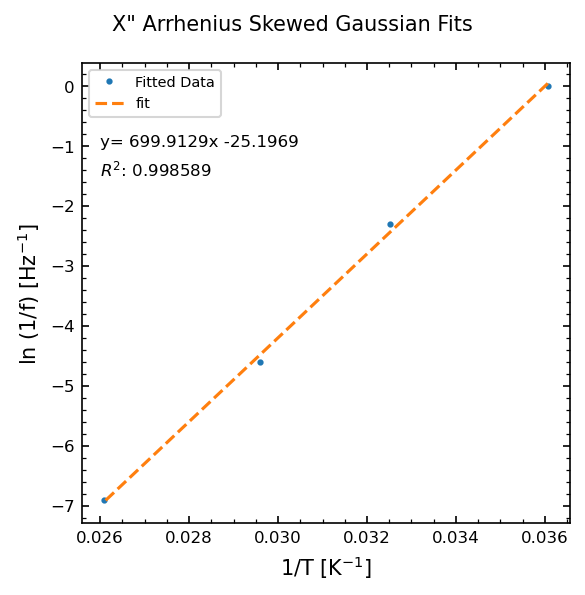

In [24]:
# Plot the data

fig = plt.figure(figsize=[4,4], dpi=150)
ax1 = plt.subplot(111) #1 row, 1 columns, position 1

ax1.plot(peak_df['1/Tp'],peak_df['ln(1/f)'],'o', markersize=2, linewidth=0, label='Fitted Data')
ax1.plot(peak_df['1/Tp'], res.intercept + res.slope*peak_df['1/Tp'], '--', label= 'fit')

# Customization
ax1.set_xlabel('1/T [$\mathrm{K^{-1}}$]', color='black', fontsize=10)
ax1.set_ylabel('ln (1/f) [$\mathrm{Hz^{-1}}$] ', color='black', fontsize=10)
ax1.legend(fontsize='x-small',frameon=True, loc='best')
ax1.minorticks_on()
ax1.tick_params(which= 'both', labelcolor='k', labelsize=8, top='bool', right= 'bool', direction='in')

#ax.annotate
ax1.annotate(f"y= {res.slope:.4f}x {res.intercept:.4f}",(0.026,-1.0), fontsize=8)
ax1.annotate(f"$R^2$: {res.rvalue**2:.6f}", (0.026, -1.5), fontsize=8)

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('X" Arrhenius Skewed Gaussian Fits', fontsize= 10)

#Save
#plt.savefig('AND100-810C_Arrhenius_Skewed_Gaussian_5K data')

plt.show()

## Estimate Magnetic Granulometry (Requires LT Hysteresis Data)

In [25]:
# Input hysteresis parameters from loop measured at LT

LT = 5 #Temperature in K (specified LT, so that one may add other temperatures, like RT or other)
Msmass = 3.81 #mass-normalized Ms
BcT = 0.104736 #Coercivity, in units of B-field (T) [B (T)= mu-zero * H (A/m)]

In [26]:
KbeV = 0.00008617333262 #Boltzmann's constant in eV to calculate deltaE
KbSI= 1.38649E-23 #Boltzmann's constant in SI to calculate blocking volumes
Muzero= 1.257e-6 #In case one wants to calculate Hk and use both parameters...

deltaEeV = (res.slope*KbeV)
Msvol = Msmass * 480000 / 92 #Determine volume-normalized Ms at LT using magnetite Ms at room temperature (480 kA/m)
BkT = 2.09*BcT #Microcoercivity in units of B field, following Worm & Jackson (1999)
Tau0s = (np.exp(res.intercept))
invT = 1/LT
Taus = (np.exp((res.slope*invT)+res.intercept))

print(deltaEeV)
print(Msvol)
print(BkT)
print(Tau0s)
print(Taus)

0.060313825880834976
19878.260869565216
0.21889823999999997
1.1405886105753433e-11
7.09234447786473e+49


In [27]:
# Calculate Particle Blocking Volumes (Vb)
Vbm3 = ((2*KbSI*LT)/(Msvol*BkT)*np.log(Taus/Tau0s)) #using Muzero: ((2*KbSI)/(Muzero*Msvol*HkT)*np.log(Taus/Tau0s))

# Calculate mean radius in nm
r3 = ((Vbm3)/((4/3)*np.pi)) #radius cubed
rm = (r3**(1/3)) #radius in meters
rnm = (rm*1000000000) #radius in nanometers

print(f"r (nm): {rnm:.1f}") #round to first decimal figure

r (nm): 10.2


## Condensed Figure for Publication

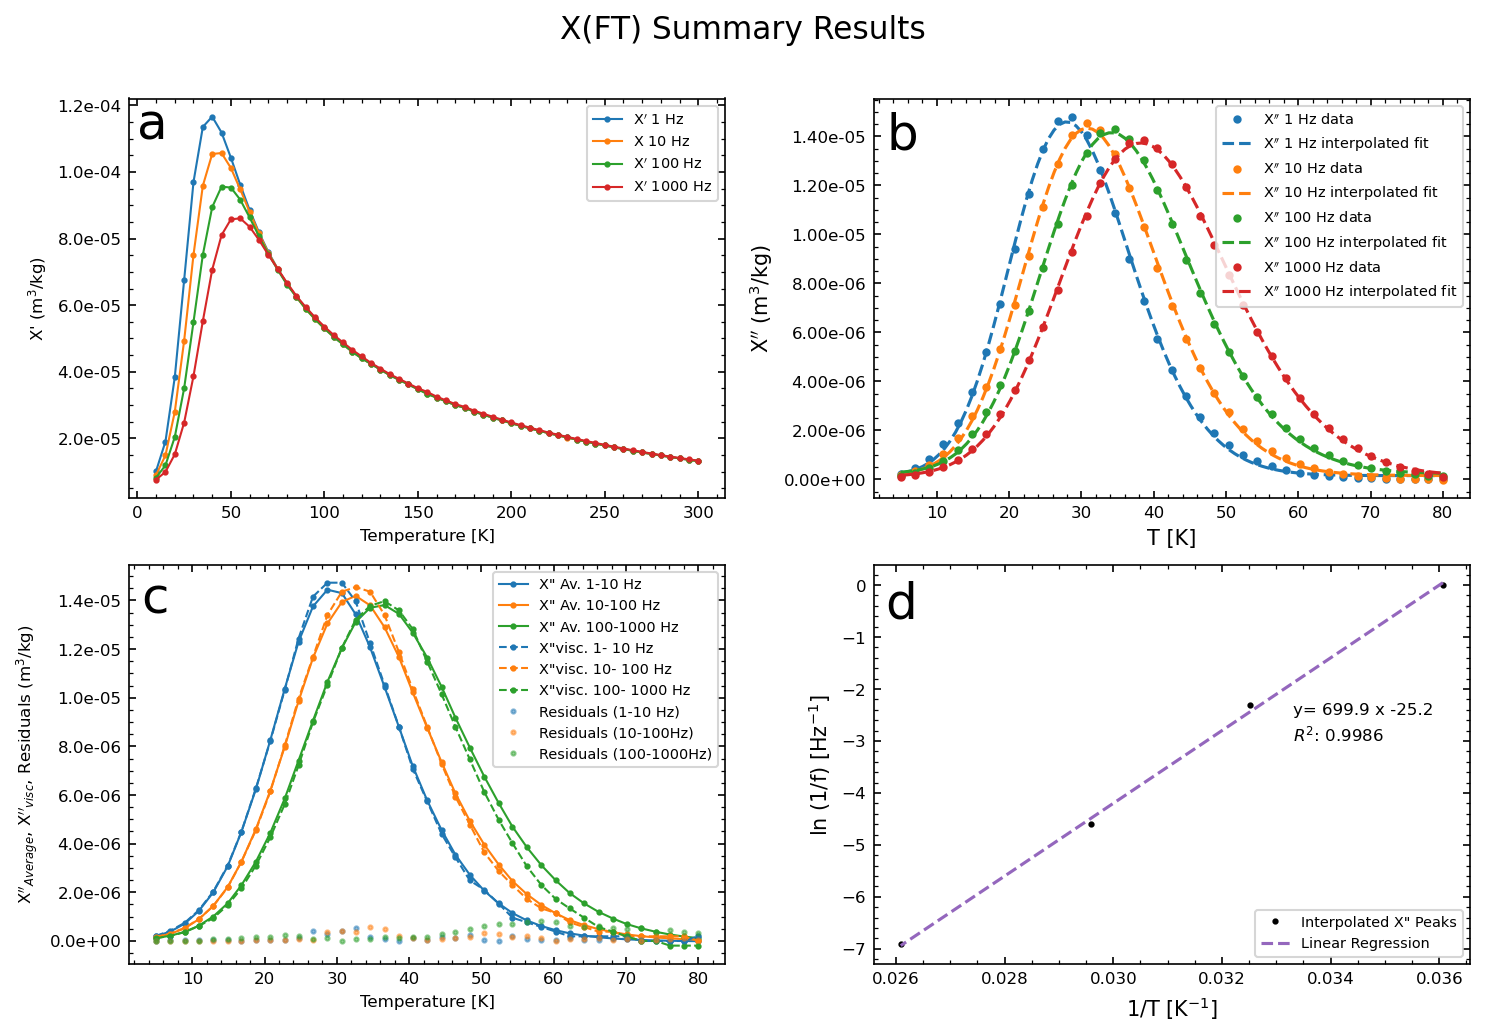

In [28]:
#Fig for Pub
fig = plt.figure(figsize=[10,7], dpi=150) #Adjust resolution as needed

# Panel 1: X' 10-300K
ax1 = plt.subplot(221) #3 row, 2 columns, position 1

ax1.plot(ct['Temp (K)'],ct["X' 1Hz"],'-o', markersize=2, linewidth=1, label="$\mathrm{X'}$ 1 Hz")
ax1.plot(ct['Temp (K)'],ct["X' 10Hz"],'-o', markersize=2, linewidth=1, label="$\mathrm{X}$ 10 Hz")
ax1.plot(ct['Temp (K)'],ct["X' 100Hz"],'-o', markersize=2, linewidth=1, label="$\mathrm{X'}$ 100 Hz")
ax1.plot(ct['Temp (K)'],ct["X' 1000Hz"],'-o', markersize=2, linewidth=1, label="$\mathrm{X'}$ 1000 Hz")

# Panel 2: Fitted X"
ax2 = plt.subplot(222) #3 row, 2 columns, position 2
# Plot data and interpolated fits for each dataset
for i, (Gx, Gy) in enumerate(datasets):
    color = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red'][i]
    label = ["$\mathrm{X''}$ 1 Hz", "$\mathrm{X''}$ 10 Hz", "$\mathrm{X''}$ 100 Hz", "$\mathrm{X''}$ 1000 Hz"][i]
    
    ax2.plot(Gx, Gy, '.', color=color, label=f'{label} data')
    ax2.plot(all_Gx_high_res[i], all_Gy_high_res[i], '--', color=color, label=f'{label} interpolated fit')

# Panel 3: X" 5-80K
ax3 = plt.subplot(223) #3 row, 2 columns, position 5
ax3.plot(ct2['Temp (K)'],((ct2["X'' 1Hz"]+ct2["X'' 10Hz"])/2),'-o', markersize=2, linewidth=1, color= 'tab:blue', label='X" Av. 1-10 Hz')
ax3.plot(ct2['Temp (K)'],((ct2["X'' 10Hz"]+ct2["X'' 100Hz"])/2),'-o', markersize=2, linewidth=1, color= 'tab:orange', label='X" Av. 10-100 Hz')
ax3.plot(ct2['Temp (K)'],((ct2["X'' 100Hz"]+ct2["X'' 1000Hz"])/2),'-o', markersize=2, linewidth=1, color= 'tab:green', label='X" Av. 100-1000 Hz')
# Panel 3: X" visc 5-80K
ax3.plot(ct2['Temp (K)'],ct2["Xvisc1"],'--o', markersize=2, linewidth=1, color='tab:blue', label='X"visc. 1- 10 Hz')
ax3.plot(ct2['Temp (K)'],ct2["Xvisc2"],'--o', markersize=2, linewidth=1, color='tab:orange', label='X"visc. 10- 100 Hz')
ax3.plot(ct2['Temp (K)'],ct2["Xvisc3"],'--o', markersize=2, linewidth=1, color='tab:green', label='X"visc. 100- 1000 Hz') 
# Panel 3 Residuals X"-X"visc 5-80K 
ax3.plot(ct2['Temp (K)'], abs(((ct2["X'' 1Hz"] + ct2["X'' 10Hz"]) / 2) - ct2["Xvisc1"]),
         'o', markersize=2, color='tab:blue', alpha=0.5, label='Residuals (1-10 Hz)')
ax3.plot(ct2['Temp (K)'], abs(((ct2["X'' 10Hz"] + ct2["X'' 100Hz"]) / 2) - ct2["Xvisc2"]),
         'o', markersize=2, color='tab:orange', alpha=0.5, label='Residuals (10-100Hz)')
ax3.plot(ct2['Temp (K)'], abs(((ct2["X'' 100Hz"] + ct2["X'' 1000Hz"]) / 2) - ct2["Xvisc3"]),
         'o', markersize=2, color='tab:green', alpha=0.5, label='Residuals (100-1000Hz)')
    
# Panel 4: Arrhenius X" skewed gaussian 5-80K
ax4 = plt.subplot(224) #3 row, 2 columns, position 5
ax4.plot(peak_df['1/Tp'],peak_df['ln(1/f)'],'o', color= 'black', markersize=2, linewidth=0, label='Interpolated X" Peaks')
ax4.plot(peak_df['1/Tp'], res.intercept + res.slope*peak_df['1/Tp'], '--', color='tab:purple', label= 'Linear Regression')

# Customization
# Panel 1: X'
ax1.set_xlabel('Temperature [K]', color='black', fontsize=8)
ax1.set_ylabel("X' ($\mathrm{m}^3$/kg)", color='black', fontsize=8)
ax1.minorticks_on()
ax1.tick_params(which= 'both', labelcolor='k', labelsize=8, top='bool', right= 'bool', direction='in')
ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
ax1.legend(fontsize='x-small',frameon=True, loc='best')

# Panel 2: Skewed X" fit
ax2.set_xlabel('T [K]', color='black', fontsize=10)
ax2.set_ylabel("$\mathrm{X''}$ ($\mathrm{m}^3$/kg)", color='black', fontsize=10)
ax2.legend(fontsize='x-small',frameon=True, loc='best')
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
ax2.minorticks_on()
ax2.tick_params(which='both', labelcolor='k', labelsize=8, top=True, right=True, direction='in')

# Panel 3: X", X" visc, Residuals
ax3.set_xlabel('Temperature [K]', color='black', fontsize=8)
ax3.set_ylabel("$\mathrm{X''}_{Average}$, $\mathrm{X''}_{visc}$, Residuals ($\mathrm{m}^3$/kg)", color='black', fontsize=8)
ax3.minorticks_on()
ax3.tick_params(which= 'both', labelcolor='k', labelsize=8, top='bool', right= 'bool', direction='in')
ax3.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
ax3.legend(fontsize='x-small',frameon=True, loc='best')

# Panel 4: Arrhenius Plot
ax4.set_xlabel('1/T [$\mathrm{K^{-1}}$]', color='black', fontsize=10)
ax4.set_ylabel('ln (1/f) [$\mathrm{Hz^{-1}}$] ', color='black', fontsize=10)
ax4.legend(fontsize='x-small',frameon=True, loc=4)
ax4.minorticks_on()
ax4.tick_params(which= 'both', labelcolor='k', labelsize=8, top='bool', right= 'bool', direction='in')
# Annotate stats
ax4.annotate(f"y= {res.slope:.1f} x {res.intercept:.1f}",(0.0333,-2.5), fontsize=8)
ax4.annotate(f"$R^2$: {res.rvalue**2:.4f}", (0.0333, -3), fontsize=8)

# Annotate Figure
ax1.annotate(f"a",([0,1.1e-4]), fontsize=24)
ax2.annotate(f"b",([3,1.35e-5]), fontsize=24)
ax3.annotate(f"c",([3,1.35e-5]), fontsize=24)
ax4.annotate(f"d",([0.0258,-0.63]), fontsize=24)

fig.tight_layout()
plt.subplots_adjust(top=0.9)

fig.suptitle('X(FT) Summary Results', fontsize= 15)

#Save
#plt.savefig('AND100-810C_AC(4FT)_for_publication')

plt.show()

## In-Phase and Out-of-Phase X 10-300K and 2-80K for Supplements

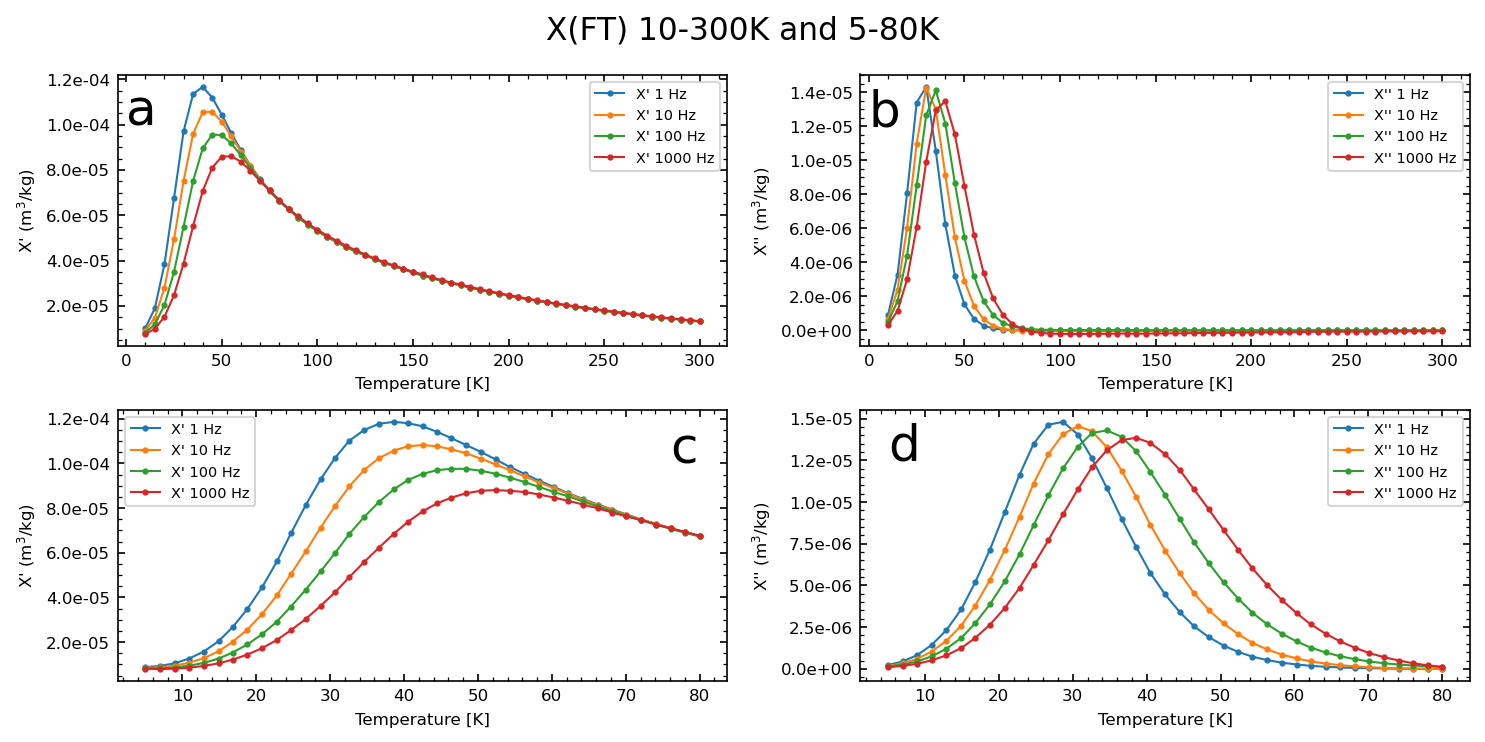

In [29]:
#Plot the data

fig = plt.figure(figsize=[10,5], dpi=150) #Adjust resolution as needed

ax1 = plt.subplot(221) #3 row, 2 columns, position 1

#10-300K
ax1.plot(ct['Temp (K)'],ct["X' 1Hz"],'-o', markersize=2, linewidth=1, label="X' 1 Hz")
ax1.plot(ct['Temp (K)'],ct["X' 10Hz"],'-o', markersize=2, linewidth=1, label="X' 10 Hz")
ax1.plot(ct['Temp (K)'],ct["X' 100Hz"],'-o', markersize=2, linewidth=1, label="X' 100 Hz")
ax1.plot(ct['Temp (K)'],ct["X' 1000Hz"],'-o', markersize=2, linewidth=1, label="X' 1000 Hz")

ax2 = plt.subplot(222) #3 row, 2 columns, position 2
ax2.plot(ct['Temp (K)'],ct["X'' 1Hz"],'-o', markersize=2, linewidth=1, label="X'' 1 Hz")
ax2.plot(ct['Temp (K)'],ct["X'' 10Hz"],'-o', markersize=2, linewidth=1, label="X'' 10 Hz")
ax2.plot(ct['Temp (K)'],ct["X'' 100Hz"],'-o', markersize=2, linewidth=1, label="X'' 100 Hz")
ax2.plot(ct['Temp (K)'],ct["X'' 1000Hz"],'-o', markersize=2, linewidth=1, label="X'' 1000 Hz")

# Customization
ax1.set_xlabel('Temperature [K]', color='black', fontsize=8)
ax1.set_ylabel("X' ($\mathrm{m}^3$/kg)", color='black', fontsize=8)
ax1.minorticks_on()
ax1.tick_params(which= 'both', labelcolor='k', labelsize=8, top='bool', right= 'bool', direction='in')
ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
ax1.legend(fontsize='x-small',frameon=True, loc='best')#, bbox_to_anchor=(1, 0.5))

ax2.set_xlabel('Temperature [K]', color='black', fontsize=8)
ax2.set_ylabel("X'' ($\mathrm{m}^3$/kg)", color='black', fontsize=8)
ax2.minorticks_on()
ax2.tick_params(which= 'both', labelcolor='k', labelsize=8, top='bool', right= 'bool', direction='in')
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
ax2.legend(fontsize='x-small',frameon=True, loc='best')

# 2-80K
ax3 = plt.subplot(223) #2 row, 2 columns, position 3
ax3.plot(ct2['Temp (K)'],ct2["X' 1Hz"],'-o', markersize=2, linewidth=1, label="X' 1 Hz")
ax3.plot(ct2['Temp (K)'],ct2["X' 10Hz"],'-o', markersize=2, linewidth=1, label="X' 10 Hz")
ax3.plot(ct2['Temp (K)'],ct2["X' 100Hz"],'-o', markersize=2, linewidth=1, label="X' 100 Hz")
ax3.plot(ct2['Temp (K)'],ct2["X' 1000Hz"],'-o', markersize=2, linewidth=1, label="X' 1000 Hz")

ax4 = plt.subplot(224) #2 row, 2 columns, position 4
ax4.plot(ct2['Temp (K)'],ct2["X'' 1Hz"],'-o', markersize=2, linewidth=1, label="X'' 1 Hz")
ax4.plot(ct2['Temp (K)'],ct2["X'' 10Hz"],'-o', markersize=2, linewidth=1, label="X'' 10 Hz")
ax4.plot(ct2['Temp (K)'],ct2["X'' 100Hz"],'-o', markersize=2, linewidth=1, label="X'' 100 Hz")
ax4.plot(ct2['Temp (K)'],ct2["X'' 1000Hz"],'-o', markersize=2, linewidth=1, label="X'' 1000 Hz")

# Customization
ax3.set_xlabel('Temperature [K]', color='black', fontsize=8)
ax3.set_ylabel("X' ($\mathrm{m}^3$/kg)", color='black', fontsize=8)
ax3.minorticks_on()
ax3.tick_params(which= 'both', labelcolor='k', labelsize=8, top='bool', right= 'bool', direction='in')
ax3.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
ax3.legend(fontsize='x-small',frameon=True, loc='best')#, bbox_to_anchor=(1, 0.5))

ax4.set_xlabel('Temperature [K]', color='black', fontsize=8)
ax4.set_ylabel("X'' ($\mathrm{m}^3$/kg)", color='black', fontsize=8)
ax4.minorticks_on()
ax4.tick_params(which= 'both', labelcolor='k', labelsize=8, top='bool', right= 'bool', direction='in')
ax4.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
ax4.legend(fontsize='x-small',frameon=True, loc='best')


#Annotate
ax1.annotate(f"a",([0,1e-4]), fontsize=24)
ax2.annotate(f"b",([0,1.2e-5]), fontsize=24)
ax3.annotate(f"c",([76,1e-4]), fontsize=24)
ax4.annotate(f"d",([5,1.25e-5]), fontsize=24)


fig.tight_layout()
plt.subplots_adjust(top=0.9)

fig.suptitle('X(FT) 10-300K and 5-80K', fontsize= 15)

#Save
#plt.savefig('AC(4FT)_10-300K_5-80K_for_supplements')

plt.show()